# Converting raw ANT .cnt
* This file will convert raw ANT-Neuro .cnt EEG files to a format that can be read by MNE-Python.
* The goal 
    * To read .cnt data using libeep library
    * Convert to numpy nDArray if not already
    * Use MNE-Pythons RawArray method to read EEG data.
* Conversion will be done using python2 because libeep was compiled with this version.
* The arrays OR MNE RawArray objects will be stored with pickle and later read with an updated version of MNE for python3

In [77]:
import os
import time
import pickle
import gzip
import libeep
import read_antcnt
import mne
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [34]:
path = '/run/media/edrias/5212-DECF/raw_data/'

In [3]:
# method to get names of all .cnt and .trg files and put them in a dictionary with raw_data folder as key
def raw_data_file_names(path):
    
    raw_data_folders = os.listdir(path)
    raw_data_dict = {}
    for folder in raw_data_folders:
        files = os.listdir(os.path.join(path, folder))
        raw_data_dict[folder] = [x for x in files if '.cnt' in x or '.trg' in x]
    return raw_data_dict

In [4]:
raw_data_dict = raw_data_file_names(path)

In [5]:
# read raw data - takes path of .cnt file.
def read_raw_cnt(path):
    return libeep.read_cnt(path)
    

In [6]:
# get file path of each .cnt file
file_dict_keys = raw_data_dict.keys()
cnt_paths = []

for key in file_dict_keys:
    files = raw_data_dict[key]
    cnt_files = [x for x in files if '.cnt' in x]
    
    for file in cnt_files:
        folder_path = os.path.join(path, key)
        cnt_file = os.path.join(folder_path, file)
        cnt_paths.append(cnt_file)
        

In [7]:
# needed to get a sample size interval 
def get_interval(sample_size, interval, divide_by = 10):
    return (sample_size/divide_by) + (interval * (sample_size/divide_by))

In [8]:
# getting intervals samples of a single .cnt file
raw_cnt = read_raw_cnt(cnt_paths[2])
samples_size = raw_cnt.get_sample_count()
print "samples size: ", samples_size
intervals = [0]

for i in range(9):
    interval = get_interval(samples_size, i)
    intervals.append(interval)
intervals.append(samples_size)
print intervals

samples size:  856037
[0, 85603, 171206, 256809, 342412, 428015, 513618, 599221, 684824, 770427, 856037]


In [9]:
# read chunk of data from each file and store it
# for i in range(len(cnt_paths[:10])):
raw = read_antcnt.read_raw_antcnt(cnt_paths[i + 1])


[0, 75640, 151280, 226920, 302560, 378200, 453840, 529480, 605120, 680760, 756404]
['Lm', 'LE1', 'Nasium', 'LE3', 'LD2', 'LD5', 'LC3', 'LC6', 'LB1', 'LB4', 'LA2', 'LA5', 'LL1', 'LL4', 'LL7', 'LL10', 'LL13', 'L3', 'L6', 'L9', 'L12', 'Z1', 'Z4', 'Z7', 'Z10', 'Z13', 'R3', 'R6', 'R9', 'R12', 'RR1', 'RR4', 'RR7', 'RR10', 'RR13', 'RA2', 'RA5', 'RB1', 'RB4', 'RC3', 'RC6', 'RD2', 'RD5', 'RE1', 'VEOG', 'RE3', 'Rm', 'RE4', 'RD1', 'RD3', 'RD4', 'RD6', 'RD7', 'RC1', 'RC2', 'RC4', 'RC5', 'RC7', 'RB2', 'RB3', 'RB5', 'RB6', 'RA1', 'RA3', 'RA4', 'RR2', 'RR3', 'RR5', 'RR6', 'RR8', 'RR9', 'RR11', 'RR12', 'R1', 'R2', 'R4', 'R5', 'R7', 'R8', 'R10', 'R11', 'R13', 'R14', 'Z2', 'Z3', 'Z5', 'Z6', 'Z8', 'Z9', 'Z11', 'Z12', 'Z14', 'L1', 'L2', 'L4', 'L5', 'L7', 'L8', 'L10', 'L11', 'L13', 'L14', 'LL2', 'LL3', 'LL5', 'LL6', 'LL8', 'LL9', 'LL11', 'LL12', 'LA1', 'LA3', 'LA4', 'LB2', 'LB3', 'LB5', 'LB6', 'LC1', 'LC2', 'LC4', 'LC5', 'LC7', 'LD1', 'LD3', 'LD4', 'LD6', 'LD7', 'LE4']
Data will be preloaded. preload=False

read_antcnt.py:235: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .cnt file
  warn('Data will be preloaded. preload=False or a string '


(75640, 128)
('event ch:', (75640,))


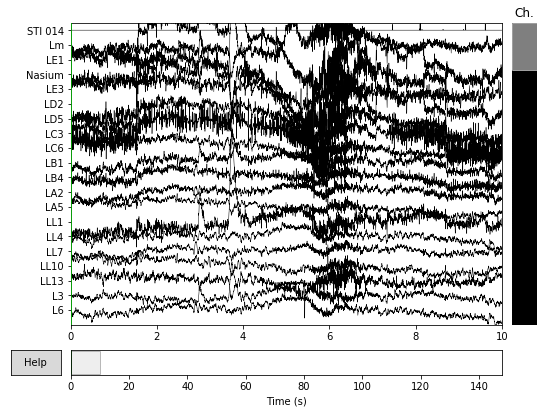

In [10]:
raw.plot();

In [ ]:
# script to the get_data and info of each object as a pickle object. 
pickle_path = '/run/media/edrias/5212-DECF/cnt_pickle_objects'
for i in range(1,len(cnt_paths)):
    raw = read_antcnt.read_raw_antcnt(cnt_paths[i])
    data = raw.get_data()
    info = raw.info
    file_name = cnt_paths[i].split('.')[0] + "_{0}".format(i) + '.cnt' #name chunks original cnt and append index to it 
    with open(os.path.join(pickle_path, file_name), 'wb') as f:
        pickle.dump(data)

In [60]:
pickle_path = '/run/media/edrias/5212-DECF/cnt_pickle_objects/'
with open(os.path.join(pickle_path, 'f.pickle'), 'wb') as f:
    pickle.dump(5, f)

In [78]:
pickle_path = '/run/media/edrias/5212-DECF/cnt_pickle_objects'
# raw = read_antcnt.read_raw_antcnt(cnt_paths[1])
data = raw.get_data()
info = raw.info
cnt_file_name = cnt_paths[1].split('.')[0] + "_{0}".format(i) + '.pickle' #name chunks original cnt and append index to it 
cnt_file_name_1 = cnt_paths[1].split('/')[-1] + '.pickle'
info_file_name = cnt_paths[1].split('.')[0] + "_info_{0}".format(i)
f = gzip.open(os.path.join(pickle_path, cnt_file_name_1), 'wb')
pickle.dump(data, f)
# with open(os.path.join(pickle_path, info_file_name), 'wb') as f:
#     pickle.dump(info, f)
    

In [80]:
file = gzip.open(os.path.join(pickle_path, cnt_file_name_1), 'rb')
data = pickle.load(file)

IOError: CRC check failed 0x6a1bdfb1 != 0x81838537L

In [70]:
# read intervaled data using read_antcnt library
# raw = read_antcnt.read_raw_antcnt(cnt_paths[1])
cnt_paths[1].split('/')[-1]

'20140331_1753.cnt'

In [74]:
# read through each interval for a .cnt file and check for errors.
# for i in range(1,len(intervals)):
#     start = time.time()
#     raw = raw_cnt.get_samples(intervals[i -1], intervals[i])
#     end = time.time()
#     elapsed = end - start
#     print "shape: ", np.array(raw).shape
#     print "elapsed time: ", elapsed
#     print raw[:100]
data

array([[-0.0071515 , -0.00714714, -0.00714475, ..., -0.00716721,
        -0.00717236, -0.00717346]])

In [13]:
# method to strip tuple of get_channels method of libeep
# raw = np.array(raw)
# def get_channels(raw_cnt):
#     channels = []
#     for i in range(raw_cnt.get_channel_count()):
#         channels.append(raw_cnt.get_channel(i)[0])
#     return channels

In [14]:
# # get channels and create info
# channels = get_channels(raw_cnt= raw_cnt)
# info = mne.create_info(ch_names= channels, sfreq=512)

In [15]:
# n_chan = raw_cnt.get_channel_count();
# n_times = raw_cnt.get_sample_count()

# data = np.empty((n_chan+1, intervals[1]), dtype=np.double)
# from numpy import asarray
# x = asarray(raw_cnt.get_samples(0,intervals[1]))
# x.shape  = (intervals[1],n_chan) 
# print(x.shape)
# data[:-1] = x.transpose() # get into a shape that can be read by MNE


In [16]:
# check how many files can't be read by libeep.
for path in cnt_paths:
    try: 
        libeep.read_cnt(path)
    except:
        print "Error with cnt: ", path

Error with cnt:  /run/media/edrias/5212-DECF/raw_data/SA20140331/20140331_1556.cnt


In [17]:
raw_cnt = libeep.read_cnt(cnt_paths[1])
n_samples = raw_cnt.get_sample_count()
n_chan = raw_cnt.get_channel_count()

In [39]:
raw

<RawANTCNT  |  None, n_channels x n_times : 129 x 75640 (147.7 sec), ~74.7 MB, data loaded>